In [46]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scipy import stats
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from scipy.io import wavfile
from scipy.fftpack import fft
from scipy import signal

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import KFold
from keras.wrappers.scikit_learn import KerasRegressor

## Importing the dataset

In [20]:
dataset = pd.read_csv(r"C:\Users\55149\Documents\Part 3 - Classification\data_all.csv", index_col=0)

## Calculating correlation (choosing best frequency window)

In [4]:
ds = dataset

# define a range of window sizes and step sizes to try
window_sizes = range(40, 200, 20)
steps = range(10, 100, 10)

# get the column names for the numerical values
num_cols = dataset.columns[3:]

# create an empty list to store the correlation values and window parameters
corr_values = []
window_params = []

# loop over the window sizes and step sizes
for window_size in window_sizes:
    for step in steps:
        # loop over the slices of columns
        for i in range(0, len(num_cols) - window_size + 1, step):
            # get the column names for the current slice
            cols = num_cols[i:i+window_size]

            # calculate the mean of the current slice
            ds['power_mean'] = ds[cols].mean(axis=1)

            # calculate the correlation between total_rain and power_mean for the current slice
            corr = np.corrcoef(ds.total_rain, ds.power_mean)[0, 1]

            # append the correlation value and window parameters to their respective lists
            corr_values.append(corr)
            window_params.append((window_size, step))

# find the index of the window parameters that yield the highest correlation value
best_idx = np.argmax(corr_values)

# get the window parameters for the best correlation
best_window_size, best_step = window_params[best_idx]

# get the column names for the best slice
best_cols = num_cols[i:i+best_window_size]

# print the best window parameters, best slice, and its correlation value
print(f"Best window size: {best_window_size}, step: {best_step}, columns: {best_cols[0]} to {best_cols[-1]}, correlation: {corr_values[best_idx]}")

Best window size: 60, step: 10, columns: 270 to 329, correlation: 0.7940108664128471


## Visualizing the best frequency range

C:\Users\55149\AppData\Local\Temp\ipykernel_14136\2586988406.py:4: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, Audiodata = wavfile.read(file)


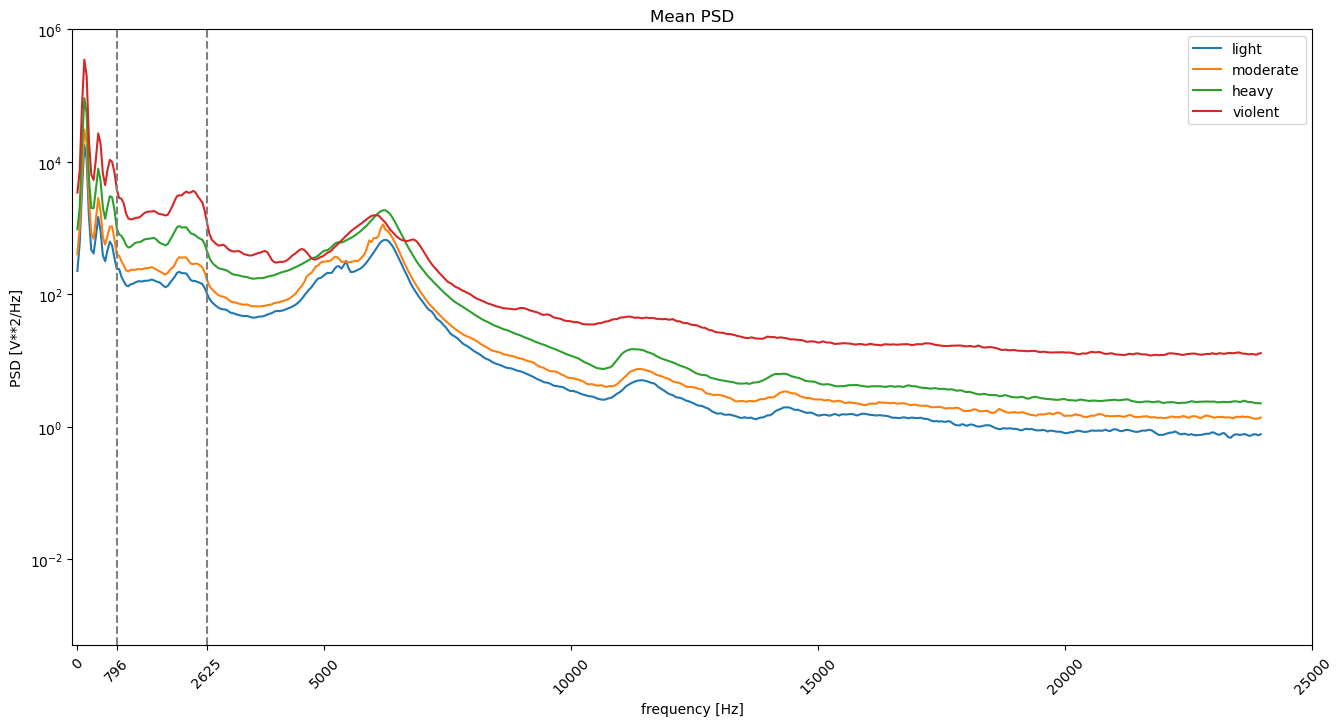

In [31]:
dataset = pd.read_csv(r"C:\Users\55149\Documents\Part 3 - Classification\data_all.csv", index_col=0)
file = r"C:\Users\55149\OneDrive\Documentos\Pluviometro\Audios\1 - Pluviometro\SMM00894_20230214_101500.wav"

fs, Audiodata = wavfile.read(file)
f, Pxx_den = signal.welch(Audiodata, fs, nperseg=1024)

#f_min = f[int(best_cols[0])]
#f_max = f[int(best_cols[-1])]

f_min = f[17]
f_max = f[56]

plt.figure(figsize=(16,8))

Pxx_den_mean = np.mean(dataset.loc[dataset.rain_class == 'light'].iloc[:,3:-1].values, axis=0)
plt.semilogy(f[0:-1], Pxx_den_mean, label='light')

Pxx_den_mean = np.mean(dataset.loc[dataset.rain_class == 'moderate'].iloc[:,3:-1].values, axis=0)
plt.semilogy(f[0:-1], Pxx_den_mean, label='moderate')

Pxx_den_mean = np.mean(dataset.loc[dataset.rain_class == 'heavy'].iloc[:,3:-1].values, axis=0)
plt.semilogy(f[0:-1], Pxx_den_mean, label='heavy')

Pxx_den_mean = np.mean(dataset.loc[dataset.rain_class == 'violent'].iloc[:,3:-1].values, axis=0)
plt.semilogy(f[0:-1], Pxx_den_mean, label='violent')

plt.legend(loc="upper right")
plt.ylim([0.5e-3, 1000000])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.title(f'Mean PSD')

# Add dotted vertical lines at f[0] and f[51]
plt.axvline(x=f_min, linestyle='--', color='gray')
plt.axvline(x=f_max, linestyle='--', color='gray')

# Set x-tick locations and labels
xticks = list(plt.xticks()[0]) + [f_min, f_max]
xticklabels = [str(int(x)) for x in plt.xticks()[0]] + [str(int(f_min)), str(int(f_max))]
plt.xticks(xticks, xticklabels)

# Set x-axis limits
plt.xlim([-100, 25000])

# Set x-axis tick rotation
plt.xticks(rotation=45)

plt.show()

## Preparing training data for model

In [32]:
dataset = dataset.loc[dataset.rain_class != 'no rain']
test_ds = dataset['2023-04-01 00:00:00':'2023-04-10 08:15:00']
dataset.drop(index=test_ds.index, inplace=True)

#X = dataset.iloc[:,3:-1].values
#y = dataset.total_rain.values

#X_test_ds = test_ds.iloc[:,3:-1].values
#y_test_ds = test_ds.total_rain.values

# Choosing the best column index
#low_index = int(best_cols[0]) + 3
#high_index = int(best_cols[-1]) + 3

#X = dataset[dataset.columns[low_index:high_index]].iloc[:,:].values
X = dataset[dataset.columns[20:60]].iloc[:,:].values
y = dataset.total_rain.values

#X_test_ds = test_ds[test_ds.columns[low_index:high_index]].iloc[:,:].values
X_test_ds = test_ds[test_ds.columns[20:60]].iloc[:,:].values
y_test_ds = test_ds.total_rain.values

dataset.rain_class.value_counts()

light       215
moderate    140
heavy       128
violent      31
Name: rain_class, dtype: int64

In [11]:
dataset.tail()

,total_rain,rain_class,filename,0,1,2,3,4,5,6,...,504,505,506,507,508,509,510,511,512,power_mean
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-05-02 06:25:00,0.4,light,SMM00894_20230502_062500.wav,18.120022,12.953046,247.19894,1769.6979,1270.6714,97.039240,32.921898,...,0.014381,0.014195,0.013995,0.013670,0.013786,0.013644,0.013387,0.013941,0.007559,0.247822
2023-05-02 09:15:00,0.4,light,SMM00894_20230502_091500.wav,413.101960,1451.193400,1717.55990,8807.4750,5886.8364,807.170800,312.436160,...,4.379531,3.256173,1.729482,1.677748,1.338628,1.754458,1.806010,3.254896,2.578217,4.205185
2023-05-02 09:20:00,0.6,moderate,SMM00894_20230502_092000.wav,12.953524,10.187672,208.25136,1272.1874,800.7740,58.195827,22.213465,...,0.009573,0.009473,0.009188,0.009153,0.009010,0.008772,0.008926,0.009483,0.005442,0.144451
2023-05-02 09:45:00,1.4,heavy,SMM00894_20230502_094500.wav,380.650700,301.671480,5935.20000,41580.6880,27139.4060,1894.484000,546.893400,...,0.255971,0.350785,0.583329,0.748898,0.794944,0.781006,0.866741,1.038423,0.562630,3.273645
2023-05-02 09:50:00,1.4,heavy,SMM00894_20230502_095000.wav,33.791836,23.595562,557.13120,3502.7307,2262.1292,161.654390,46.613148,...,0.022018,0.021288,0.020071,0.019673,0.019711,0.019634,0.019281,0.019750,0.010544,0.374471


## Random Forest

In [33]:
# Splitting dataset into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

In [34]:
# Define the range of hyperparameters to test
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Define the scoring function (mean squared error)
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Create a random forest regression model
rf_model = RandomForestRegressor()

# Create a grid search object with 5-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring=scorer, cv=kfold, verbose=2, n_jobs=-1)

# Fit the grid search object to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding mean squared error
print("Best parameters: ", grid_search.best_params_)
print("Best mean squared error: {:.2f}".format(np.abs(grid_search.best_score_)))

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


C:\Users\55149\Anaconda3\envs\new_env\lib\site-packages\sklearn\ensemble\_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Best parameters:  {'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}
Best mean squared error: 0.82


In [35]:
# Create a new random forest regression model with the best parameters found
best_rf_model = RandomForestRegressor(n_estimators=grid_search.best_params_['n_estimators'],
                                       max_features=grid_search.best_params_['max_features'],
                                       max_depth=grid_search.best_params_['max_depth'],
                                       min_samples_split=grid_search.best_params_['min_samples_split'],
                                       min_samples_leaf=grid_search.best_params_['min_samples_leaf'])

# Fit the model to the training data
best_rf_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = best_rf_model.predict(X_test)

C:\Users\55149\Anaconda3\envs\new_env\lib\site-packages\sklearn\ensemble\_forest.py:414: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


In [36]:
best_rf_model.score(X_test,y_test)

0.656606713364838

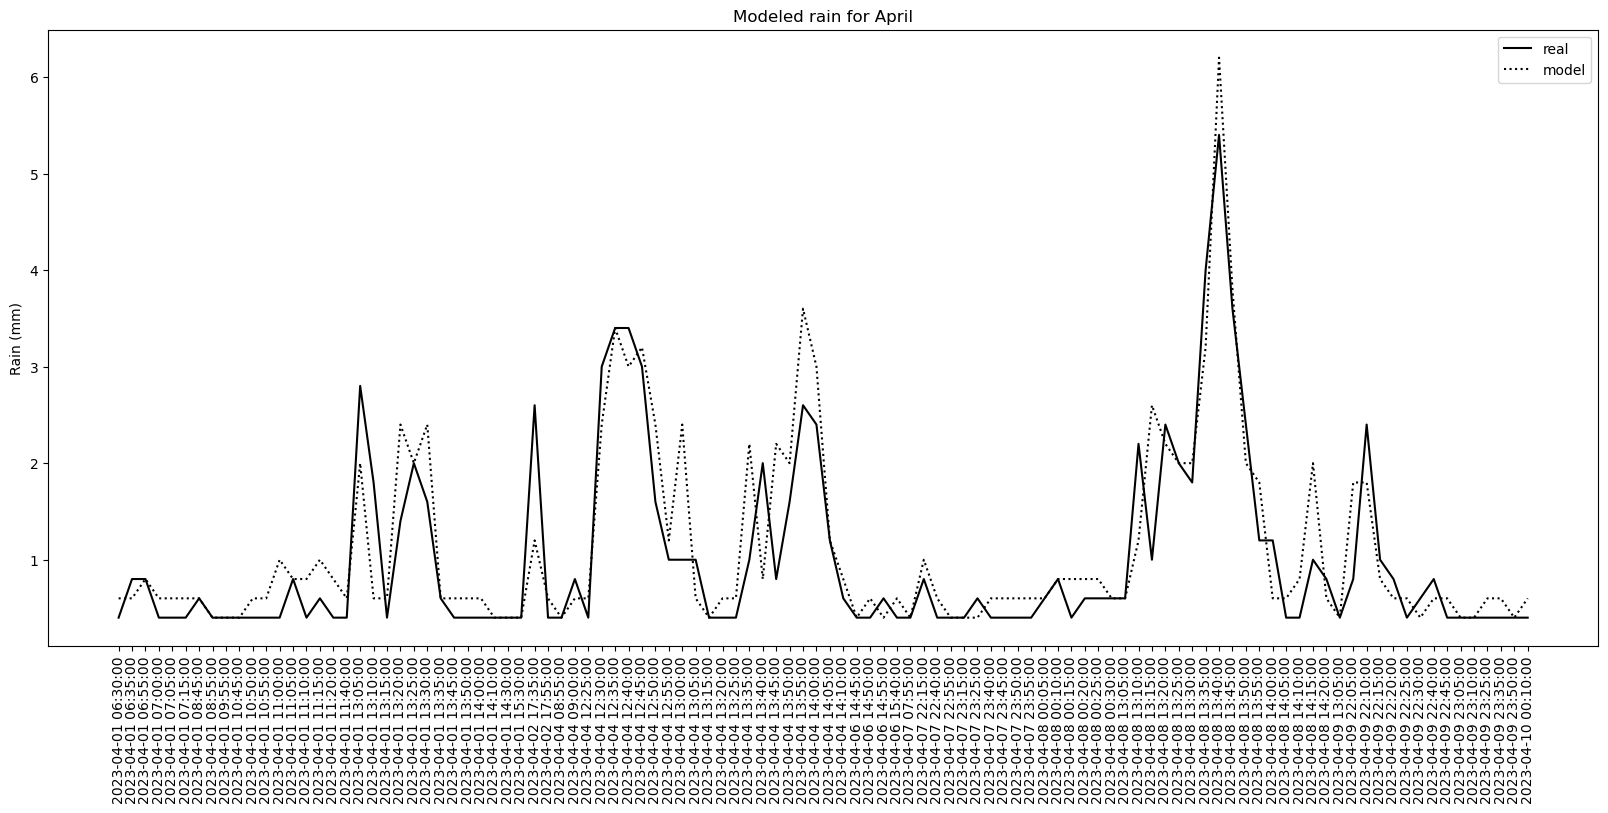

In [37]:
y_pred_test = best_rf_model.predict(X_test_ds)

plt.figure(figsize=(20,8))
plt.plot(test_ds.index,y_test_ds, color='black', label='real')
plt.plot(test_ds.index,(np.round(y_pred_test / 0.2) * 0.2), color='black', linestyle='dotted', label='model')
plt.ylabel('Rain (mm)')
plt.title('Modeled rain for April')
plt.legend()
plt.xticks(rotation=90)
plt.show()

In [38]:
print(sum((np.round(y_pred_test / 0.2) * 0.2)))
print(sum(y_test_ds))

119.59999999999994
107.60000000000002


In [39]:
np.corrcoef(y_test_ds, (np.round(y_pred_test / 0.2) * 0.2))[0, 1]

0.8756153056715084

In [40]:
from sklearn.metrics import r2_score

r2_score(y_test_ds, (np.round(y_pred_test / 0.2) * 0.2))

0.730325644504749

## Dense Neural Network

In [9]:
from keras.models import Sequential
from keras.layers import Dense

In [45]:
x = dataset.iloc[:,20:60]

for column in x.columns:
    x[column] = (x[column] - min(x[column]))/(max(x[column]) - min(x[column]))
    
X = x.values
y = dataset.total_rain.values

In [56]:
kf = KFold(n_splits=5, shuffle=True)

# Define a function to create the model
def create_model(num_layers=2, num_neurons=32, optimizer='rmsprop', epochs=20, batch_size=1):
    model = Sequential()
    model.add(Dense(num_neurons, input_dim=40, activation='relu'))
    for i in range(num_layers-1):
        model.add(Dense(num_neurons, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
    model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=0)
    return model

# Wrap the Keras model in a scikit-learn estimator
model = KerasRegressor(build_fn=create_model, verbose=0)

# Define the grid of hyperparameters to search
param_grid = {
    'num_layers': [1, 2, 3],
    'num_neurons': [16, 32, 64],
    'optimizer': ['adam', 'rmsprop'],
    'epochs': [10, 20, 30],
    'batch_size': [1, 16, 32, 64],
}

# Perform grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=kf)
grid_result = grid.fit(X, y)

# Print the best hyperparameters and corresponding mean score
print('Best: %f using %s' % (grid_result.best_score_, grid_result.best_params_))

C:\Users\55149\AppData\Local\Temp\ipykernel_14136\3042372025.py:15: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


Best: -0.834405 using {'batch_size': 1, 'epochs': 30, 'num_layers': 2, 'num_neurons': 32, 'optimizer': 'adam'}


In [57]:
# Best hyperparameters on the entire dataset
best_epochs = grid_result.best_params_['epochs']
best_batch_size = grid_result.best_params_['batch_size']
best_num_layers = grid_result.best_params_['num_layers']
best_num_neurons = grid_result.best_params_['num_neurons']
best_optimizer = grid_result.best_params_['optimizer']

In [58]:
# Training model
model = create_model(num_layers=best_num_layers, num_neurons=best_num_neurons, optimizer=best_optimizer)
model.fit(X, y, epochs=best_epochs, batch_size=best_batch_size)

Epoch 1/30
514/514 [==============================] - 1s 3ms/step - loss: 0.8942 - mae: 0.4789
Epoch 2/30
514/514 [==============================] - 1s 3ms/step - loss: 0.8739 - mae: 0.4769
Epoch 3/30
514/514 [==============================] - 1s 3ms/step - loss: 0.8697 - mae: 0.4684
Epoch 4/30
514/514 [==============================] - 1s 3ms/step - loss: 0.8613 - mae: 0.4635
Epoch 5/30
514/514 [==============================] - 1s 3ms/step - loss: 0.8270 - mae: 0.4735
Epoch 6/30
514/514 [==============================] - 1s 3ms/step - loss: 0.8211 - mae: 0.4588
Epoch 7/30
514/514 [==============================] - 1s 3ms/step - loss: 0.8705 - mae: 0.4691
Epoch 8/30
514/514 [==============================] - 1s 2ms/step - loss: 0.8578 - mae: 0.4635
Epoch 9/30
514/514 [==============================] - 1s 3ms/step - loss: 0.9060 - mae: 0.4695
Epoch 10/30
514/514 [==============================] - 1s 3ms/step - loss: 0.9336 - mae: 0.4813
Epoch 11/30
514/514 [============================

In [59]:
x = test_ds.iloc[:,20:60]

for column in x.columns:
    x[column] = (x[column] - min(x[column]))/(max(x[column]) - min(x[column]))
    
x_test_ds = x.values
y_test_ds = test_ds.total_rain.values

In [60]:
# Use the trained model to make predictions on test data
y_pred_test = model.predict(x_test_ds)

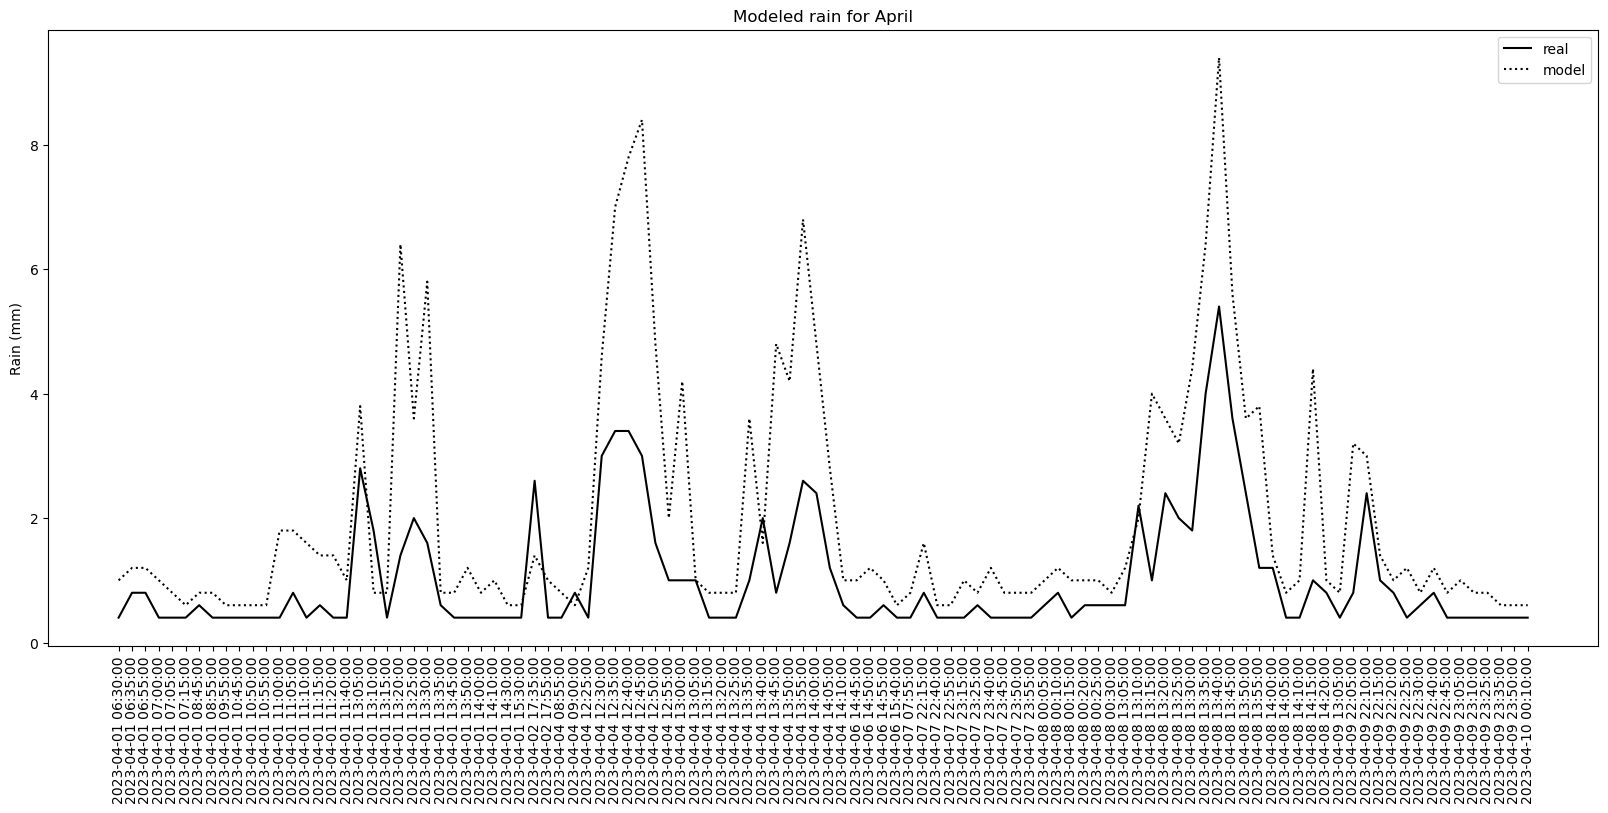

In [61]:
plt.figure(figsize=(20,8))
plt.plot(test_ds.index,y_test_ds, color='black', label='real')
plt.plot(test_ds.index,(np.round(y_pred_test / 0.2) * 0.2), color='black', linestyle='dotted', label='model')
plt.ylabel('Rain (mm)')
plt.title('Modeled rain for April')
plt.legend()
plt.xticks(rotation=90)
plt.show()

In [63]:
print(sum((np.round(y_pred_test / 0.2) * 0.2)))
print(sum(y_test_ds))

[215.00005]
107.60000000000002


In [66]:
y_test_ds.shape

(106,)

In [67]:
np.corrcoef(y_test_ds, (np.round(y_pred_test.ravel() / 0.2) * 0.2))[0, 1]

0.8404470217961806

In [68]:
r2_score(y_test_ds, (np.round(y_pred_test.ravel() / 0.2) * 0.2))

-1.8532366812030774